**кластеризатор DBSCAN**

Евгений Борисов esborisov@sevsu.ru

In [1]:
import numpy as np
from numpy import random as rng
import numpy.ma as ma

import matplotlib.pyplot as plt

In [2]:
# from sklearn.datasets import make_blobs

# X,_ = make_blobs(n_samples=1024,centers=5,cluster_std=rng.uniform(size=5)+.7 )
# display( X.shape )

# fig, ax = plt.subplots(figsize=(6,5))
# ax.scatter( x=X[:,0], y=X[:,1], s=2, alpha=0.5 )
# ax.grid()
# plt.show()

(1024, 2)

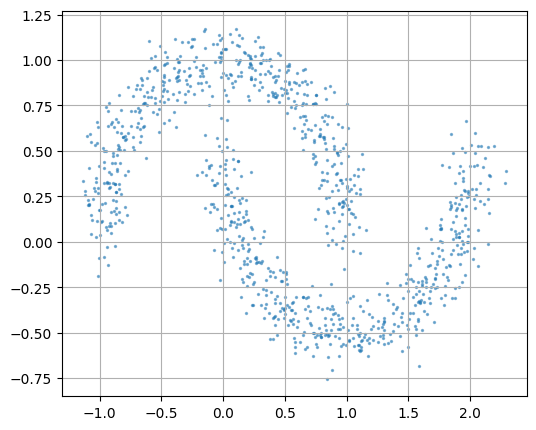

In [3]:
from sklearn.datasets import make_moons

X,_ = make_moons(n_samples=1024, noise=.1)
display(X.shape)

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter( x=X[:,0], y=X[:,1], s=2, alpha=0.5 )
ax.grid()
plt.show()

In [4]:
from sklearn.metrics.pairwise import euclidean_distances as metric

In [5]:
# медиана расстояний 
ma.median( 
    ma.masked_array( 
        metric(X),
        mask=np.triu(np.ones(X.shape[0]))
    ) 
)

1.1713664749269075

In [ ]:
# 1. выбираем рандомную точку из необработанных ;
#
# 2. формируем новый кластер радиуса R ;
#
# 3. если количество точек в кластере < K, 
#    то точки помечаются как шум, переход на п.1 ;
#
# 4. формируем подкластеры радиуса R вокруг каждой точки найденного кластера ;
#
# 5. проверяем все найденные подкластеры:
#    если количество точек в подкластере < K,
#    то точки помечаются как граничные
#    иначе помечаем точки как корневые и повторяем для каждой них рекуррентно п.4 

In [6]:
class DBScanClustering:
    
    def __init__(self,metric=metric,max_cluster_radius=.1,min_cluster_size=10):
        self._metric = metric
        self._radius = max_cluster_radius
        self._csize = min_cluster_size
        
    def fit(self,X): 
        return self
    
    def predict(self,X):
        return self._build_cluster( # запускаем процес кластеризации
            self._metric(X), # матрица расстояний
            { 'clusters': [], 'noise': set(), } # пустая структура для результатов кластеризации
        ) 
    
    def _build_cluster(self,D,result):
        n,free_idx = self._get_init_point(result,D.shape[0]) # выбрать стартовую точку
        # print(f'init {n}')
        if n<0: return result # нет свободных точек, завершаем кластеризацию
        
        # формируем кластер радиуса R вокруг центра n
        p_idx = self._assemble_cluster(D,n,free_idx)

        if len(p_idx)<self._csize: # мало точек в кластере
            # print(f'p_idx {len(p_idx)} to noise')
            result['noise'] = result['noise'].union([n]) # шумовые точки
            # выбираем новый центр, повторяем поиск
            return self._build_cluster(D,result)
        
        # print(f'p_idx {len(p_idx)} to cluster')
        # формируем новый кластер
        result['clusters'].append( { 'core': set(), 'marginal': set(), } )
        return self._check_core(D,result,p_idx)

    
    def _assemble_cluster(self,D,n,free_idx): # индексы точек вокруг центра n в радиусе R
        free_idx_ = list(free_idx)+[n]
        mask = np.ones(len(D),dtype=np.uint8)
        mask[free_idx_] = 0
        D_ = ma.masked_array(D[n,:], mask=mask) # исключаем размеченные из поиска
        return np.unique( ma.where( D_<self._radius )[0] ) 

    
    @classmethod
    def _get_init_point(cls,result,max_index):
        if len(result['clusters'])<1: # кластеров нет, все точки свободные
            return rng.randint(max_index),list(range(max_index)) # выбираем рандомную точку
        # список неразмеченных (свободных) точек
        p_free = cls._get_free_point_indices(result,max_index) 
        # print(len(p_free))
        if len(p_free)>0: 
            # случайно выбираем из неразмеченных точек
            return rng.choice( np.array(list(p_free)) ),p_free
        return -1,[] # нет свободных точек
    
    @staticmethod
    def _get_free_point_indices(result,max_index): # строим список неразмеченных (свободных) точек
      # список размеченных точек 
        p_used = set.union(*[
                c['core'].union(c['marginal']) 
                for c in result['clusters'] 
            ]).union(result['noise'])
        # список неразмеченных точек 
        return set(range(max_index)) - p_used    
                    
    # проверяем точки кластера
    def _check_core(self,D,result,p_idx):
        # строим список неразмеченных (свободных) точек
        free_idx = self._get_free_point_indices(result,D.shape[0]) 

        # формируем кластеры радиуса R вокруг центров из p_idx
        clusters_idx = { n : self._assemble_cluster(D,n,free_idx) for n in p_idx }
        assert len(clusters_idx)>0

        p_idx = [] # новые центры для проверки
        for n,c_idx in clusters_idx.items(): # проверка кластера
            if len(c_idx)<self._csize: # мало точек в кластере
                # добавляем центр в граничные точки
                result['clusters'][-1]['marginal'] = result['clusters'][-1]['marginal'].union([n]) 
                # выкидываем центр из корневых точек
                result['clusters'][-1]['core'] = result['clusters'][-1]['core'].difference([n]) 
                
            else: # достаточно точек в кластере 
                core_new_idx = set(c_idx).difference( result['clusters'][-1]['core']) # новые точки в core
                # корневые точки
                result['clusters'][-1]['core'] = result['clusters'][-1]['core'].union(core_new_idx) 
                p_idx.extend(list(core_new_idx)) # точки для проверки

        if len(p_idx)>0: return self._check_core(D,result,p_idx)
        

        return self._build_cluster(D,result) # нет новый точек для проверки, создаём новый кластер

In [11]:
# result = DBScanClustering(max_cluster_radius=1.1,min_cluster_size=3).predict(X)

result = DBScanClustering(max_cluster_radius=.1,min_cluster_size=5).predict(X)

In [12]:
len(result['clusters'])

5

In [13]:
# markers = ('.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
# b: blue, g: green, r: red, c: cyan, m: magenta, y: yellow, k: black, w: white
color_list = 'bgrcm'*50 

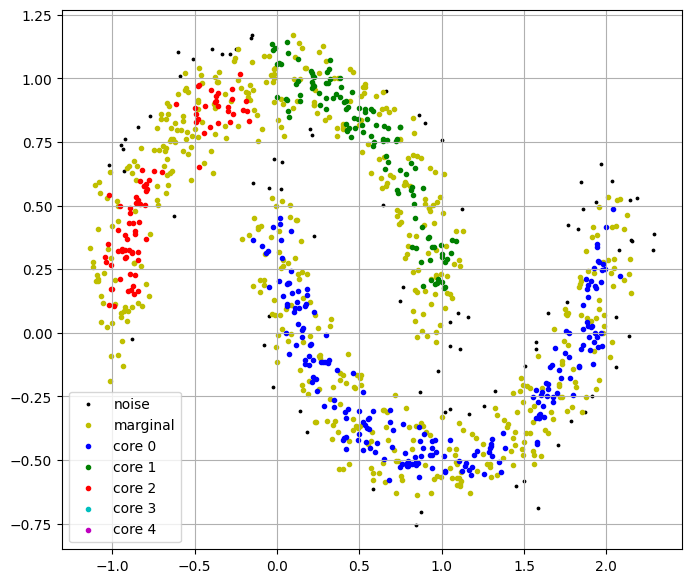

In [14]:
fig, ax = plt.subplots(figsize=(8,7))

noise_idx = list(result['noise'])
ax.scatter( x=X[noise_idx,0], y=X[noise_idx,1], s=3, c='black', label='noise' )

for n,cluster in enumerate(result['clusters']):
    core_idx = list(cluster['core'])
    marginal_idx = list(cluster['marginal'])
    #ax.scatter( x=X[:,0], y=X[:,1], s=2, alpha=0.5, c=color_list[n] )
    ax.scatter( x=X[marginal_idx,0], y=X[marginal_idx,1],marker='.',c='y', label=('marginal' if n==0 else ''))
    ax.scatter( x=X[core_idx,0], y=X[core_idx,1], marker='.', c=color_list[n], label=f'core {n}' )

ax.grid()
ax.legend()

plt.show()